1. Imports & Data Preprocessing

In [2]:
import numpy as np
import pandas as pd
import random
import time
import os
from datetime import datetime
import gc

import gower
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K, optimizers
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Add, Input, ActivityRegularization, Dropout

# your existing model‐creation imports:
# from your_module import create_generator, create_discriminator, compute_metrics, infinite_data_stream

BASE_PATH = "./counterfactuals"

if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)


date = datetime.now().strftime('%Y-%m-%d')
EXPERIMENT_PATH = f"{BASE_PATH}/diabetes_{date}"
MODELS_EXPERIMENT_PATH = f"{BASE_PATH}/diabetes_2020-09-09"
if not os.path.exists(EXPERIMENT_PATH):
    os.makedirs(EXPERIMENT_PATH)
    
    
INITIAL_CLASS = 0
DESIRED_CLASS = 1
N_CLASSES = 2

ModuleNotFoundError: No module named 'numpy'

In [2]:


# 1.1 Preprocess (and keep raw df for Gower)
def preprocess_data_german(df_path):
    df = pd.read_csv(df_path, sep=' ', skiprows=1, header=None)
    df.columns = [
        'Status','Month','Credit_History','Purpose','Credit_Amount',
        'Savings','Employment','Installment_Rate','Personal_Status','Other_Debtors',
        'Residence_Duration','Property','Age','Other_Installment_Plans','Housing',
        'Existing_Credits','Job','Num_Liable_People','Telephone','Foreign_Worker','Outcome'
    ]
    # mappings...
    status_map = {'A11':'<0','A12':'0–200','A13':'>=200','A14':'none'}
    # … (as before) …
    df['Status'] = df['Status'].map(status_map)
    # apply all mappings similarly…

    raw_df = df.copy()  # for Gower + cluster summary

    # now encode
    ord_cols = ['Status','Credit_History','Savings','Employment']
    le = LabelEncoder()
    for c in ord_cols:
        df[c] = le.fit_transform(df[c])

    nom_cols = ['Purpose','Personal_Status','Other_Debtors','Property',
                'Other_Installment_Plans','Housing','Job','Telephone','Foreign_Worker']
    df = pd.get_dummies(df, columns=nom_cols, drop_first=True)

    # split X/Y
    Y = df['Outcome'].replace({1:0,2:1})
    X = df.drop(columns=['Outcome'])
    features = list(X.columns)

    # train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X.values, to_categorical(Y), test_size=0.2, random_state=2020
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, features, raw_df

# run it:
X_train, X_test, y_train, y_test, features, raw_df = preprocess_data_german(
    'statlog_german_credit_data/german.data'
)




In [3]:

# Load the classifier model
filename = f"{EXPERIMENT_PATH}/classifier.keras"
classifier = load_model(filename)
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.trainable = False
print(f"Classifier loaded from {filename}") 

# Load the autoencoder model
filename = f"{EXPERIMENT_PATH}/autoencoder.keras" 
autoencoder = load_model(filename)
# Ensure the autoencoder is compiled with the same optimizer and loss function  
autoencoder.compile(optimizer='nadam', loss='mse')

print(f"Autoencoder loaded from {filename}")

2025-07-15 10:42:57.286525: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-15 10:42:57.436189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-15 10:42:57.436258: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-15 10:42:57.438506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-15 10:42:57.438547: I tensorflow/compile

Classifier loaded from ./counterfactuals/diabetes_2025-07-15/classifier.keras
Autoencoder loaded from ./counterfactuals/diabetes_2025-07-15/autoencoder.keras


ead NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-15 10:42:58.015693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
def compute_reconstruction_error(x, autoencoder):
    """Compute ∞-norm reconstruction error via autoencoder."""
    preds = autoencoder.predict(x)
    preds_flat = preds.reshape((preds.shape[0], -1))
    x_flat = x.reshape((x.shape[0], -1))
    # ∞-norm per sample, then average
    return np.mean(np.max(np.abs(preds_flat - x_flat), axis=1))

def print_training_information(generator, classifier, X_test, iteration, autoencoder):
    """Print diagnostic metrics during training."""
    X_gen = generator.predict(X_test)
    clf_test = classifier.predict(X_test)
    clf_gen  = classifier.predict(X_gen)
    delta_clf = (clf_gen - clf_test)[:, DESIRED_CLASS]

    recon_error = np.mean(compute_reconstruction_error(X_gen, autoencoder))
    l1_dist     = np.mean(np.abs(X_gen - X_test))

    print('='*88)
    print(f"Iteration {iteration} @ {datetime.now()}")
    print(f"Autoencoder reconstruction error (∞-norm): {recon_error:.3f}")
    print(f"Counterfactual prediction gain (0→1): {delta_clf.mean():.3f}")
    print(f"L1 distance (lower better): {l1_dist:.3f}")
    
def format_metric(metric):
    """Return a formatted version of a metric, with the confidence interval."""
    metric = np.array(metric)  # Ensure metric is a NumPy array
    return f"{metric.mean():.3f} ± {1.96*metric.std()/np.sqrt(len(metric)):.3f}"

def compute_metrics(samples, counterfactuals, latencies, classifier, autoencoder,
                    batch_latency=None):
    """ Summarize the relevant metrics in a dictionary. """
    reconstruction_error = compute_reconstruction_error(counterfactuals, autoencoder)
    delta = np.abs(samples-counterfactuals)
    l1_distances = delta.reshape(delta.shape[0], -1).sum(axis=1)
    prediction_gain = (
        classifier.predict(counterfactuals)[:, DESIRED_CLASS] - 
        classifier.predict(samples)[:, DESIRED_CLASS]
    )

    metrics = dict()
    metrics["reconstruction_error"] = format_metric(np.array([reconstruction_error]))
    metrics["prediction_gain"] = format_metric(prediction_gain)
    metrics["sparsity"] = format_metric(l1_distances)
    metrics["latency"] = format_metric(latencies)
    batch_latency = batch_latency if batch_latency else sum(latencies)
    metrics["latency_batch"] = f"{batch_latency:.3f}"

    return metrics


def generate_fake_samples(x, generator):
    """Use the input generator to generate samples."""
    return generator.predict(x)

def data_stream(x, y=None, batch_size=500):
    """Generate batches until exhaustion of the input data."""
    n_train = x.shape[0]
    if y is not None:
        assert n_train == len(y)
    n_complete_batches, leftover = divmod(n_train, batch_size)
    n_batches = n_complete_batches + bool(leftover)

    perm = np.random.permutation(n_train)
    for i in range(n_batches):
        batch_idx = perm[i * batch_size:(i + 1) * batch_size]
        if y is not None:
            output = (x[batch_idx], y[batch_idx])
        else:
            output = x[batch_idx]
        yield output


def infinite_data_stream(x, y=None, batch_size=500):
    """Infinite batch generator."""
    batches = data_stream(x, y, batch_size=batch_size)
    while True:
        try:
            yield next(batches)
        except StopIteration:
            batches = data_stream(x, y, batch_size=batch_size)
            yield next(batches)

def create_generator(in_shape=(X_train.shape[1],), residuals=True):
    """Define and compile the residual generator of the CounteRGAN."""
    generator_input = Input(shape=in_shape, name='generator_input')
    generator = Dense(64, activation='relu')(generator_input)
    generator = Dense(32, activation='relu')(generator)
    generator = Dense(64, activation='relu')(generator)
    generator = Dense(in_shape[0], activation='tanh')(generator)
    generator_output = ActivityRegularization(l1=0., l2=1e-6)(generator)
    
    if residuals:
        generator_output = Add(name="output")([generator_input, generator_output])

    return Model(inputs=generator_input, outputs=generator_output)


def create_discriminator(in_shape=(X_train.shape[1],)):
    """ Define a neural network binary classifier to classify real and generated 
    examples."""
    model = Sequential([
        Dense(128, activation='relu', input_shape=in_shape),
        Dropout(0.2),
        Dense(1, activation='sigmoid'),
    ], name="discriminator")
    optimizer = optimizers.legacy.Adam(learning_rate=0.0005, beta_1=0.5, decay=1e-8)
    model.compile(optimizer, 'binary_crossentropy', ['accuracy'])
    return model



2. Clustering on Raw Data (Gower + Complete Linkage, k=4)

In [5]:
# 2.1 Compute Gower distance
D = gower.gower_matrix(raw_df.drop(columns=['Outcome']))

# 2.2 Agglomerative clustering with precomputed distance
k = 4
cluster_model = AgglomerativeClustering(
    n_clusters=k,
    metric='precomputed',
    linkage='complete'
)
labels = cluster_model.fit_predict(D)
raw_df['Cluster'] = labels

raw_Y = raw_df['Outcome'].replace({1:0,2:1})
raw_X = raw_df.drop(columns=['Outcome'])
raw_df_features = list(raw_X.columns)

raw_X_train, raw_X_test, raw_y_train, raw_y_test = train_test_split(
        raw_X.values, to_categorical(raw_Y), test_size=0.2, random_state=2020
    )

#assign last column to test_cluster_labels
test_cluster_labels = raw_X_test[:, -1]
raw_X_test = raw_X_test[:, :-1]  # remove cluster label from test set
raw_X_train = raw_X_train[:, :-1]  # remove cluster label from train set

print("Cluster sizes:", raw_df['Cluster'].value_counts().to_dict())




Cluster sizes: {0: 369, 2: 288, 3: 197, 1: 145}


3. Build Profile Templates (Immutable vs Actionable + cost_weights)

In [6]:
# 3.1 Identify immutable by low-variance (numeric) or unanimous mode (categorical)
num_cols = raw_df.select_dtypes(include='number').columns.drop(['Outcome','Cluster'])
cat_cols = raw_df.select_dtypes(include='object').columns

grp = raw_df.groupby('Cluster')
num_std = grp[num_cols].std()
cat_mode_pct = grp[cat_cols].agg(lambda s: s.value_counts(normalize=True).iloc[0])

# 3.2 Build raw→encoded mapping
encoded_df = pd.DataFrame(X_train, columns=features)
raw_to_encoded = {}
for raw_feat in raw_df.columns.drop(['Outcome','Cluster']):
    matches = [i for i,f in enumerate(features) if f.startswith(raw_feat)]
    if matches:
        raw_to_encoded[raw_feat] = matches

# 3.3 Construct profiles
cluster_profiles = []
for cid in sorted(raw_df['Cluster'].unique()):
    imm = []
    # low-std numeric
    for f in num_cols:
        if num_std.loc[cid,f] < 0.05:
            imm.append(f)
    # unanimous categorical
    for f in cat_cols:
        if cat_mode_pct.loc[cid,f] > 0.90:
            imm.append(f)
    # always truly immutable:
    for g in ['Age','Foreign_Worker']:
        if g not in imm:
            imm.append(g)

    # actionable = all other **raw** features
    all_raw = list(num_cols) + list(cat_cols)
    act = [f for f in all_raw if f not in imm]

    # 3.4 Compute cost_weights ∝ 1/std or 1/(1−mode)
    cw = {}
    eps=1e-6
    for f in act:
        if f in num_std.columns:
            cw[f] = 1.0/(num_std.loc[cid,f]+eps)
        else:
            pct = cat_mode_pct.loc[cid,f]
            cw[f] = 1.0/((1-pct)+eps)
    # normalize so avg=1
    total = sum(cw.values()); n_act=len(cw)
    for f in cw:
        cw[f] = float(cw[f]*n_act/total)

    cluster_profiles.append({
        'cluster_id':cid,
        'immutable_features':imm,
        'actionable_features':act,
        'cost_weights':cw,
        'lambda': 0.0001,  # default lambda for CounterGAN
    })

# inspect
for p in cluster_profiles:
    print(f"Cluster {p['cluster_id']}: {len(p['immutable_features'])} imm, "
          f"{len(p['actionable_features'])} act")


Cluster 0: 4 imm, 16 act
Cluster 1: 3 imm, 17 act
Cluster 2: 2 imm, 18 act
Cluster 3: 4 imm, 16 act


4. CounterGAN Definition & Training Helpers

In [7]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def define_countergan(generator, discriminator, classifier,
                      cost_weights: dict, sparsity_lambda: float=0.0):
    discriminator.trainable = False
    classifier.trainable    = False

    x_in = Input(shape=(X_train.shape[1],), name='cf_input')
    x_gen = generator(x_in)
    y_disc = discriminator(x_gen)
    y_clf  = classifier(x_gen)

    delta = x_gen - x_in  # (batch, n_features)
    # build cost vector in the **encoded** space
    cost_vec = np.zeros((X_train.shape[1],), dtype='float32')
    for raw, idxs in raw_to_encoded.items():
        if raw in cost_weights:
            for i in idxs:
                cost_vec[i] = cost_weights[raw]
    CV = K.constant(cost_vec)

    sparse_loss = K.sum(K.abs(delta)*CV, axis=1)
    cgan = Model(inputs=x_in, outputs=[y_disc,y_clf], name='countergan')
    cgan.add_loss(sparsity_lambda * K.mean(sparse_loss))
    cgan.compile(
        optimizer=optimizers.legacy.RMSprop(learning_rate=2e-4, decay=1e-8),
        loss=['binary_crossentropy','categorical_crossentropy'],
        loss_weights=[1.0,1.0]
    )
    return cgan

def train_countergan(
    n_disc, n_gen, n_iter,
    classifier, discriminator, generator,
    batches,
    cost_weights, sparsity_lambda=0.0,
    weighted_version=False
):
    cgan = define_countergan(
        generator, discriminator, classifier,
        cost_weights, sparsity_lambda
    )
    for it in range(n_iter):
        # discriminator step
        discriminator.trainable=True
        for _ in range(n_disc):
            xr, _ = next(batches)
            xf    = generator.predict(xr)
            Xd = np.vstack([xr,xf])
            yd = np.concatenate([np.ones(len(xr)),np.zeros(len(xf))])
            perm = np.random.permutation(len(yd))
            Xd, yd = Xd[perm], yd[perm]
            if weighted_version:
                scores = classifier.predict(Xd)[:,DESIRED_CLASS]
                mask = yd==1; scores[mask]/= (scores[mask].mean()+1e-8); scores[~mask]=1.
                discriminator.train_on_batch(Xd,yd,sample_weight=scores)
            else:
                discriminator.train_on_batch(Xd,yd)
        # generator step
        discriminator.trainable=False
        for _ in range(n_gen):
            xi,_ = next(batches)
            yf    = np.ones(len(xi))
            yt    = to_categorical([DESIRED_CLASS]*len(xi),N_CLASSES)
            if weighted_version:
                sw = classifier.predict(xi)[:,DESIRED_CLASS]
                cgan.train_on_batch(xi,[yf,yt],sample_weight=sw)
            else:
                cgan.train_on_batch(xi,[yf,yt])
    return cgan


5. Train & Save Per-Cluster GANs

In [30]:
from collections import defaultdict
# 5.1 Organize cluster data
cluster_data = defaultdict(lambda: {'X':[],'y':[]})
for x,y,lbl in zip(X_train,y_train,labels):
    cluster_data[lbl]['X'].append(x); cluster_data[lbl]['y'].append(y)
for cid in cluster_data:
    cluster_data[cid]['X']=np.vstack(cluster_data[cid]['X'])
    cluster_data[cid]['y']=np.vstack(cluster_data[cid]['y'])

best_per_cluster = {}
best_per_cluster[0] = {'lambda': 0.01, 'gain': 0.19, 'sparsity': 3.871}
best_per_cluster[1] = {'lambda': 0.013, 'gain': 0.101, 'sparsity': 4.51}
best_per_cluster[2] = {'lambda': 0.01, 'gain': 0.202, 'sparsity': 4.298}
best_per_cluster[3] = {'lambda': 0.003, 'gain': 0.225, 'sparsity': 5.85}

{1: {'lambdas': [0.01, 0.011, 0.012, 0.013, 0.014, 0.015],
  'sparsity': [5.193, 4.334, 4.479, 4.51, 4.028, 4.208],
  'gain': [0.108, 0.048, 0.033, 0.101, 0.064, 0.051]}}

# # 5.2 Train
# for prof in cluster_profiles:
#     cid = prof['cluster_id']
#     gen = create_generator(residuals=True)
#     disc= create_discriminator()
#     batches = infinite_data_stream(cluster_data[cid]['X'],cluster_data[cid]['y'],128)
#     train_countergan(
#         n_disc=2, n_gen=4, n_iter=1000,  
#         classifier=classifier, discriminator=disc, generator=gen,
#         batches=batches,
#         cost_weights=prof['cost_weights'],
#         sparsity_lambda=best_per_cluster[cid]['lambda'],  
#         weighted_version=True
#     )
#     print(best_per_cluster[cid])
#     gen.save(f'generators/cluster_{cid}.h5')

# 5.2 Train
# Select only cluster 1 in prof
prof = next(p for p in cluster_profiles if p['cluster_id'] == 1)


cid = prof['cluster_id']
gen = create_generator(residuals=True)
disc= create_discriminator()
batches = infinite_data_stream(cluster_data[cid]['X'],cluster_data[cid]['y'],128)
train_countergan(
    n_disc=2, n_gen=4, n_iter=1000,  
    classifier=classifier, discriminator=disc, generator=gen,
    batches=batches,
    cost_weights=prof['cost_weights'],
    sparsity_lambda=best_per_cluster[cid]['lambda'],  
    weighted_version=True
)
print(best_per_cluster[cid])
gen.save(f'generators/cluster_{cid}.h5')

4/4 [==============================] - 0s 2ms/step
{'lambda': 0.013, 'gain': 0.101, 'sparsity': 4.51}


/home/ahmed/Desktop/prototype/.venv/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6. Generate Personalized CFs & Baseline Eval

In [8]:
# 6.1 Load generators
gens = {cid: tf.keras.models.load_model(f'generators/cluster_{cid}.h5') 
        for cid in range(k)}

# 6.2 Generate & collect
personalized_cfs = []
personalized_lat = []
for i, x in enumerate(X_test):
    cid = test_cluster_labels[i]
    gen = gens[cid]
    t0  = time.time()
    cf  = gen.predict(x[None])[0]
    personalized_cfs.append(cf)
    personalized_lat.append(1000*(time.time()-t0))
personalized_cfs = np.vstack(personalized_cfs)

# 6.3 Evaluate
pers_metrics = compute_metrics(
    X_test, personalized_cfs,
    np.array(personalized_lat,dtype='float32'),
    classifier, autoencoder
)
base_cfs = create_generator(residuals=True).predict(X_test)
base_metrics = compute_metrics(X_test, base_cfs,
    np.zeros(len(X_test)), classifier, autoencoder
)
print("Personalized:", pers_metrics)
print("Baseline:    ", base_metrics)


7/7 [==============================] - 0s 1ms/step
Personalized: {'reconstruction_error': '2.882 ± 0.000', 'prediction_gain': '0.177 ± 0.036', 'sparsity': '4.893 ± 0.236', 'latency': '32.722 ± 3.068', 'latency_batch': '6544.480'}
Baseline:     {'reconstruction_error': '2.952 ± 0.000', 'prediction_gain': '-0.111 ± 0.027', 'sparsity': '8.343 ± 0.415', 'latency': '0.000 ± 0.000', 'latency_batch': '0.000'}


In [9]:
# Assume in Step 6 you also recorded per-cluster metrics in a dict, e.g.:
cluster_eval = {
    cid: compute_metrics(
        X_test[test_cluster_labels==cid],
        personalized_cfs[test_cluster_labels==cid],
        np.array(personalized_lat)[test_cluster_labels==cid],
        classifier, autoencoder
    )
    for cid in range(k)
}

rows = []
for cid, m in cluster_eval.items():
    rows.append({
        "cluster_id":           cid,
        "size":                 int((test_cluster_labels==cid).sum()),
        "prediction_gain":      float(m["prediction_gain"].split("±")[0]),
        "reconstruction_error": float(m["reconstruction_error"].split("±")[0]),
        "sparsity":             float(m["sparsity"].split("±")[0]),
        "latency":              float(m["latency"].split("±")[0])
    })

df_cluster_metrics = pd.DataFrame(rows).sort_values("cluster_id")
df_cluster_metrics.to_csv("cluster_metrics_summary.csv", index=False)
print(df_cluster_metrics)


3/3 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step
   cluster_id  size  prediction_gain  reconstruction_error  sparsity  latency
0           0    71            0.162                 2.996     4.430   30.946
1           1    39            0.061                 3.199     4.047   31.535
2           2    51            0.266                 2.881     4.927   31.756
3           3    39            0.204                 2.361     6.535   38.408


7/7 [==============================] - 0s 2ms/step
| Metric               |   Baseline |   Personalized |
|:---------------------|-----------:|---------------:|
| Prediction Gain      |      0.029 |          0.177 |
| Reconstruction Error |      2.679 |          2.882 |
| Sparsity (L1)        |      6.969 |          4.893 |
| Latency (ms)         |      0     |         32.722 |
| Batch Latency (ms)   |    136.206 |       6544.48  |


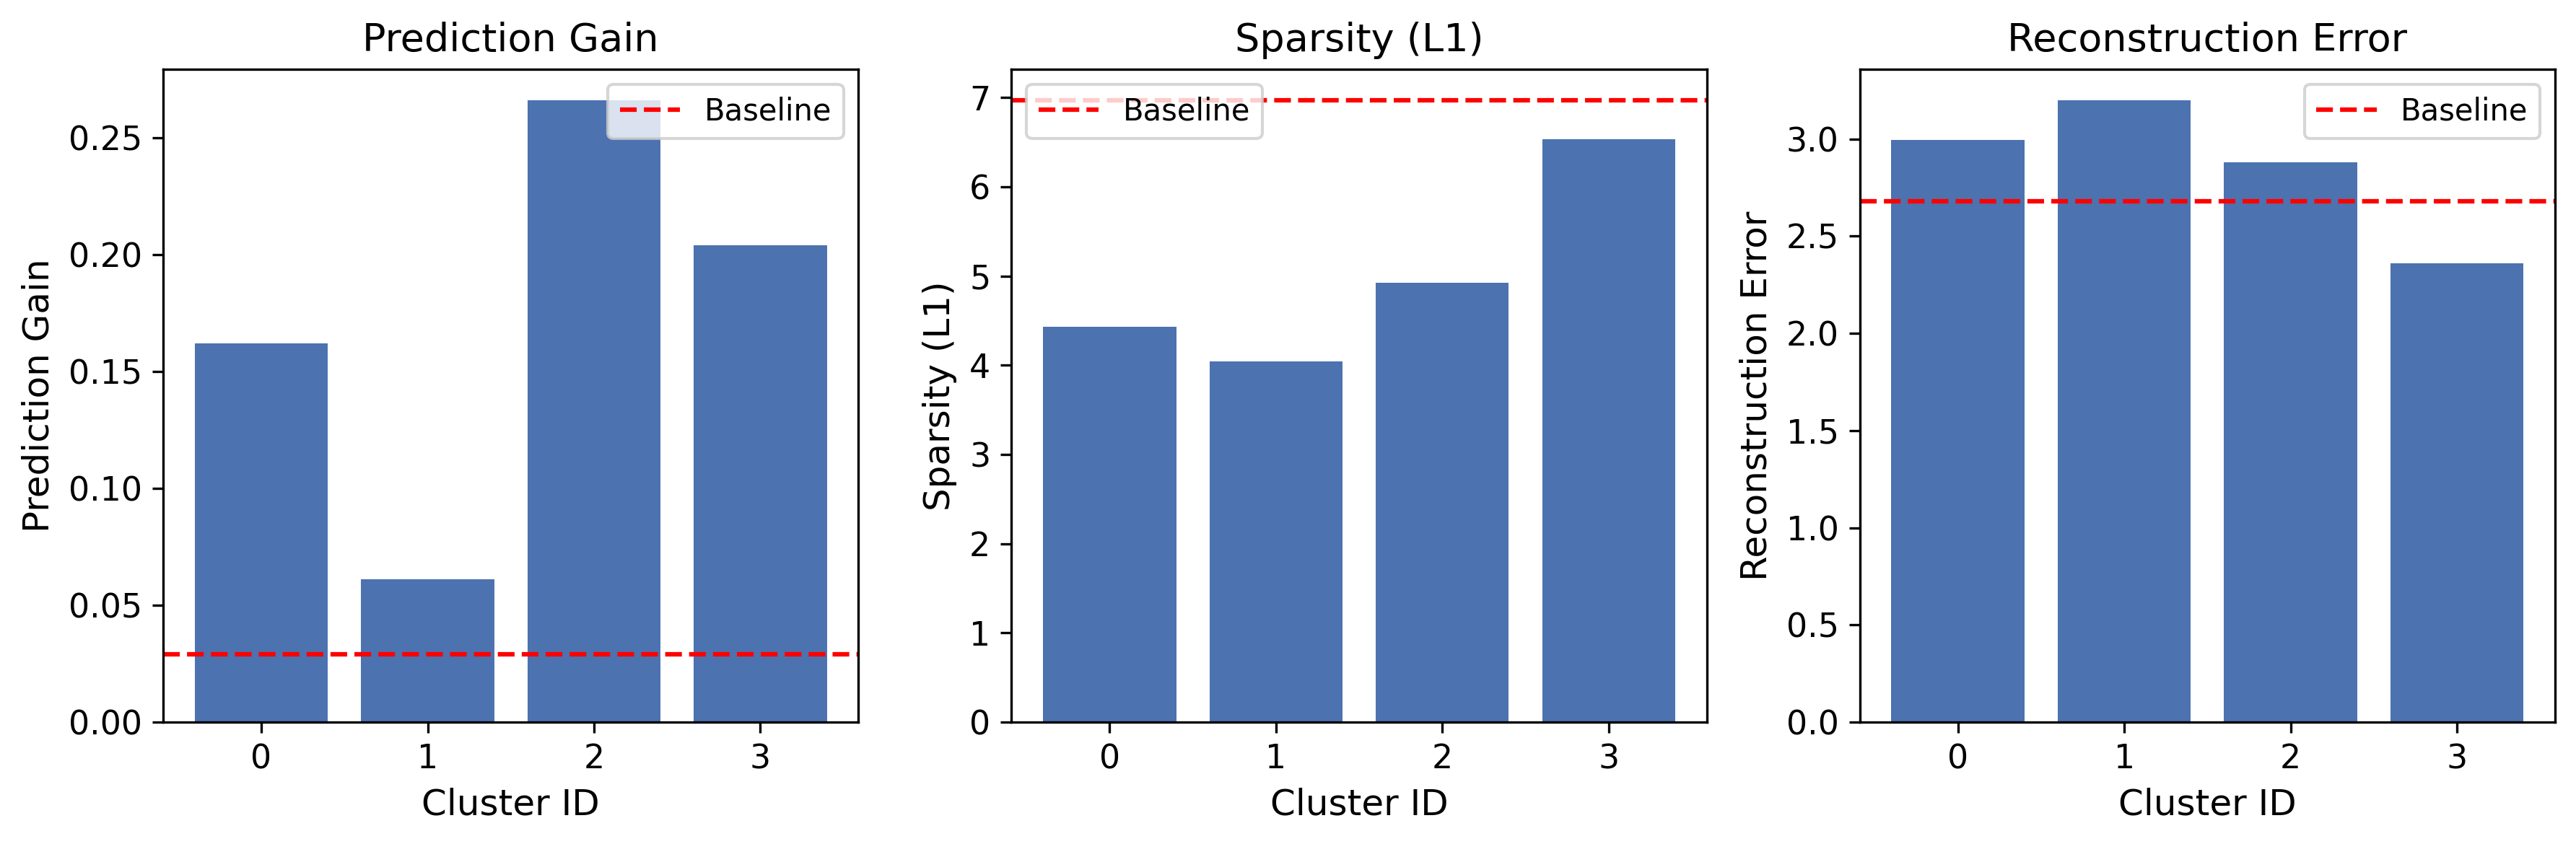

In [16]:

# — 1) Recompute overall personalized metrics (if you didn’t already) —
personalized_overall = compute_metrics(
    samples         = X_test,
    counterfactuals = personalized_cfs,
    latencies       = personalized_lat,
    classifier      = classifier,
    autoencoder     = autoencoder
)

# parse the strings into floats
def parse(m):
    return float(m.split("±")[0])

baseline = {
    "reconstruction_error": 2.679,
    "prediction_gain":      0.029,
    "sparsity":             6.969,
    "latency":              0.0,      # per-sample
    "latency_batch":       136.206
}

personal = {
    "reconstruction_error": parse(personalized_overall["reconstruction_error"]),
    "prediction_gain":      parse(personalized_overall["prediction_gain"]),
    "sparsity":             parse(personalized_overall["sparsity"]),
    "latency":              parse(personalized_overall["latency"]),
    "latency_batch":       float(personalized_overall["latency_batch"])
}

# — 2) Comparison table —
df_compare = pd.DataFrame({
    "Metric": ["Prediction Gain", "Reconstruction Error", "Sparsity (L1)", "Latency (ms)", "Batch Latency (ms)"],
    "Baseline": [
        baseline["prediction_gain"],
        baseline["reconstruction_error"],
        baseline["sparsity"],
        baseline["latency"],
        baseline["latency_batch"]
    ],
    "Personalized": [
        personal["prediction_gain"],
        personal["reconstruction_error"],
        personal["sparsity"],
        personal["latency"],
        personal["latency_batch"]
    ]
})
print(df_compare.to_markdown(index=False))

import matplotlib.pyplot as plt

# Define metrics and their corresponding y-labels
metrics = {
    "prediction_gain": "Prediction Gain",
    "sparsity": "Sparsity (L1)",
    "reconstruction_error": "Reconstruction Error"
}

# Initialize subplot
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=300)

# Font sizes
label_fontsize = 12
tick_fontsize = 11
legend_fontsize = 10
title_fontsize = 13

# Plot each metric
for i, (metric_key, ylabel) in enumerate(metrics.items()):
    ax = axes[i]
    ax.bar(df_cluster_metrics["cluster_id"], df_cluster_metrics[metric_key], color="#4C72B0")
    
    # Baseline horizontal line
    ax.axhline(baseline[metric_key], color="red", linestyle="--", label="Baseline")
    
    ax.set_title(ylabel, fontsize=title_fontsize)
    ax.set_xlabel("Cluster ID", fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    ax.set_xticks(df_cluster_metrics["cluster_id"])
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    if ylabel == "Sparsity (L1)":
        ax.legend(loc="upper left", fontsize=legend_fontsize)
    else:
        ax.legend(loc="upper right", fontsize=legend_fontsize)


# Adjust layout and save
plt.tight_layout()
plt.savefig("bar_charts_clusters.png", bbox_inches="tight")
plt.show()


7. Grid‐Search per-Cluster λ

In [12]:
# def grid_search_lambda_for_cluster(
#     cid, cluster_data, classifier, autoencoder,
#     base_gen_fn, base_disc_fn, X_test, test_cluster_labels,
#     # lambdas=[1e-4,5e-4,1e-3,5e-3,1e-2,5e-2],
#     lambdas=[ 0.0005, 0.001,0.0015,0.002,0.0025,0.003,0.0035,0.004,0.0045,0.005, 0.01],
#     min_gain=0.10
# ):
#     results = []
#     idxs = np.where(test_cluster_labels==cid)[0]
#     Xc = X_test[idxs]; zlat=np.zeros(len(idxs),dtype='float32')
#     best={'lambda':None,'gain':-np.inf,'sparsity':np.inf}
#     for lam in lambdas:
#         gen = base_gen_fn()
#         disc = base_disc_fn()
#         train_countergan(
#             2,4,100,
#             classifier,disc,gen,
#             infinite_data_stream(cluster_data[cid]['X'],cluster_data[cid]['y'],128),
#             cost_weights=cluster_profiles[cid]['cost_weights'],
#             sparsity_lambda=lam, weighted_version=True
#         )
#         cfs = gen.predict(Xc)
#         m = compute_metrics(Xc,cfs,zlat,classifier,autoencoder)
#         gn = float(m['prediction_gain'].split(' ±')[0])
#         sp = float(m['sparsity'].split(' ±')[0])
#         results.append({'lambda':lam, 'gain':gn, 'sparsity':sp})
#         if gn>=min_gain and sp<best['sparsity']:
#             best={'lambda':lam,'gain':gn,'sparsity':sp}
#     return best, results

# # # # example:
# # best_per_cluster = {
# #     cid: grid_search_lambda_for_cluster(
# #         cid, cluster_data, classifier, autoencoder,
# #         create_generator, create_discriminator,
# #         X_test, test_cluster_labels
# #     )
# #     for cid in range(k)
# # }
# # print(best_per_cluster)

# # example:
# cidx = [0,2,3]  # list of cluster IDs

# # Loop over cluster IDs if you want results for multiple clusters
# best_per_cluster = {}
# results_per_cluster = {}
# for cid in cidx:
#     best_per_cluster[cid], results_per_cluster[cid] = grid_search_lambda_for_cluster(
#         cid, cluster_data, classifier, autoencoder,
#         create_generator, create_discriminator,
#         X_test, test_cluster_labels
#     )
#     print(best_per_cluster)
#     print(results_per_cluster)  


In [13]:
# best_per_cluster[0] = {'lambda': 0.01, 'gain': 0.19, 'sparsity': 3.871}
# best_per_cluster[1] = {'lambda': 0.01, 'gain': 0.099, 'sparsity': 5.523}
# best_per_cluster[2] = {'lambda': 0.01, 'gain': 0.202, 'sparsity': 4.298}
# best_per_cluster[3] = {'lambda': 0.003, 'gain': 0.225, 'sparsity': 5.85}

# best_per_cluster[3] = {'lambda': 0.003, 'gain': 0.225, 'sparsity': 5.85}

2/2 [==============================] - 0s 4ms/step


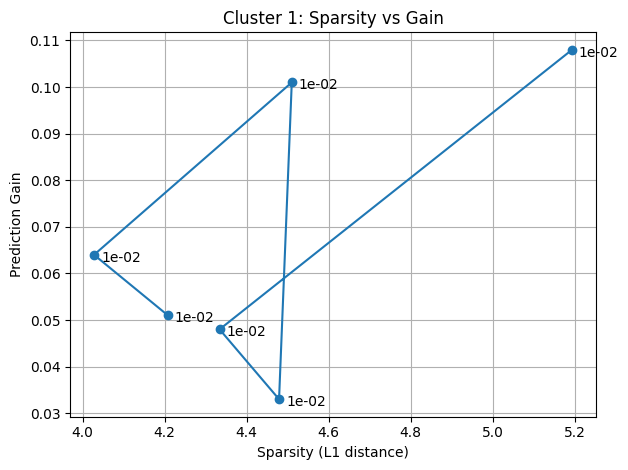

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# 1) choose the λ grid you want to explore
lambdas = [10e-3, 11e-3, 12e-3,13e-3, 14e-3, 15e-3]



# 2) the clusters you want to sweep
cluster_ids = [1]   # e.g. only cluster 1, or [0,1,2,3]

# 3) prepare a dict to hold results
tradeoff = {
    cid: {"lambdas": [], "sparsity": [], "gain": []}
    for cid in cluster_ids
}

# 4) loop clusters × λ
for cid in cluster_ids:
    idxs     = np.where(test_cluster_labels == cid)[0]
    Xc_test  = X_test[idxs]
    zeros_lat= np.zeros(len(idxs), dtype=np.float32)
    prof     = cluster_profiles[cid]

    for lam in lambdas:
        # rebuild & train the cluster's CounterGAN
        gen  = create_generator(residuals=True)
        disc = create_discriminator()
        train_countergan(
            n_disc=2,
            n_gen=4,
            n_iter=300,
            classifier=classifier,
            discriminator=disc,
            generator=gen,
            batches=infinite_data_stream(
                cluster_data[cid]["X"],
                cluster_data[cid]["y"],
                batch_size=128
            ),
            cost_weights=prof["cost_weights"],
            sparsity_lambda=lam,
            weighted_version=True
        )

        # generate CFs & evaluate
        cfs = gen.predict(Xc_test)
        m   = compute_metrics(
            samples=Xc_test,
            counterfactuals=cfs,
            latencies=zeros_lat,
            classifier=classifier,
            autoencoder=autoencoder
        )
        sp  = float(m["sparsity"].split(" ±")[0])
        gn  = float(m["prediction_gain"].split(" ±")[0])

        tradeoff[cid]["lambdas"].append(lam)
        tradeoff[cid]["sparsity"].append(sp)
        tradeoff[cid]["gain"].append(gn)
        del gen, disc, cfs, m
        K.clear_session()
        gc.collect()

    # 5) plot the trade‐off curve for this cluster
    spars = tradeoff[cid]["sparsity"]
    gains = tradeoff[cid]["gain"]
    lams  = tradeoff[cid]["lambdas"]

    plt.figure()
    plt.plot(spars, gains, marker="o", linestyle="-")
    for x, y, l in zip(spars, gains, lams):
        plt.annotate(f"{l:.0e}", xy=(x, y),
                     xytext=(5, -5), textcoords="offset points")
    plt.xlabel("Sparsity (L1 distance)")
    plt.ylabel("Prediction Gain")
    plt.title(f"Cluster {cid}: Sparsity vs Gain")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()



In [26]:
tradeoff

{1: {'lambdas': [0.01, 0.011, 0.012, 0.013, 0.014, 0.015],
  'sparsity': [5.193, 4.334, 4.479, 4.51, 4.028, 4.208],
  'gain': [0.108, 0.048, 0.033, 0.101, 0.064, 0.051]}}

In [28]:
# update labmda in each profile in cluster_profiles
for prof in cluster_profiles:
    cid = prof['cluster_id']
    if cid in best_per_cluster:
        prof['lambda'] = best_per_cluster[cid]['lambda']
        print(f"Cluster {cid} lambda updated to {prof['lambda']:.6f}")
    else:
        print(f"Cluster {cid} not found in best_per_cluster, keeping original lambda {prof['lambda']:.6f}")

cluster_profiles[1]['lambda'] = 0.013



cluster_profiles

Cluster 0 lambda updated to 0.010000
Cluster 1 lambda updated to 0.038000
Cluster 2 lambda updated to 0.010000
Cluster 3 lambda updated to 0.003000


[{'cluster_id': 0,
  'immutable_features': ['Other_Debtors',
   'Other_Installment_Plans',
   'Foreign_Worker',
   'Age'],
  'actionable_features': ['Month',
   'Credit_Amount',
   'Installment_Rate',
   'Residence_Duration',
   'Existing_Credits',
   'Num_Liable_People',
   'Status',
   'Credit_History',
   'Purpose',
   'Savings',
   'Employment',
   'Personal_Status',
   'Property',
   'Housing',
   'Job',
   'Telephone'],
  'cost_weights': {'Month': 0.04651374732050165,
   'Credit_Amount': 0.00021630481630709352,
   'Installment_Rate': 0.4623129659367606,
   'Residence_Duration': 0.47076917866241647,
   'Existing_Credits': 0.825358036520123,
   'Num_Liable_People': 1.4594238229085799,
   'Status': 0.9305502126442583,
   'Credit_History': 1.051468914744919,
   'Purpose': 0.7987557560558205,
   'Savings': 1.3014678717498986,
   'Employment': 0.8345743405558227,
   'Personal_Status': 1.0225824646645643,
   'Property': 0.8421270369095182,
   'Housing': 2.863220451900515,
   'Job': 1.82

8. Bump Cost‐Weights by Δx

In [17]:
# def bump_cost_weights(cluster_profiles, X_test, cfs, test_cluster_labels,
#                       features, bump_factor=1.3, percentile=80):
#     feat2idx = {f:i for i,f in enumerate(features)}
#     for prof in cluster_profiles:
#         cid = prof['cluster_id']
#         idxs= np.where(test_cluster_labels==cid)[0]
#         if len(idxs)==0: continue
#         deltas = np.abs(cfs[idxs]-X_test[idxs]).mean(axis=0)
#         for raw,cw in prof['cost_weights'].items():
#             # raw might map to multiple idx
#             mean_d = np.mean([deltas[i] for i in raw_to_encoded[raw]])
#             prof.setdefault('mean_delta',{})[raw]=mean_d
#         thresh = np.percentile(list(prof['mean_delta'].values()),percentile)
#         for f,mean_d in prof['mean_delta'].items():
#             if mean_d>thresh:
#                 old = prof['cost_weights'][f]
#                 prof['cost_weights'][f] = old * bump_factor
#                 print(f"Cluster {cid}: bumped {f} {old:.2f}→{prof['cost_weights'][f]:.2f}")
#     return cluster_profiles

# Old_cluster_profiles = cluster_profiles.copy()
# # Usage after an initial personalized run:
# bumped_cluster_profiles = bump_cost_weights(
#     cluster_profiles, X_test, personalized_cfs, test_cluster_labels, features,
#     bump_factor=1.5, percentile=75
# )


In [18]:
# # 5.2 reTrain
# for prof in bumped_cluster_profiles:
#     cid = prof['cluster_id']
#     gen = create_generator(residuals=True)
#     disc= create_discriminator()
#     batches = infinite_data_stream(cluster_data[cid]['X'],cluster_data[cid]['y'],128)
#     train_countergan(
#         n_disc=2, n_gen=4, n_iter=1000,  
#         classifier=classifier, discriminator=disc, generator=gen,
#         batches=batches,
#         cost_weights=prof['cost_weights'],
#         sparsity_lambda=prof['lambda'], # use the updated lambda
#         weighted_version=True
#     )
#     gen.save(f'generators/cluster_{cid}.h5')